In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from tqdm import tqdm
import random

In [2]:

'''from google.colab import drive
drive.mount('/content/drive')
'''

Mounted at /content/drive


In [3]:
'''
xls_path = '/content/drive/MyDrive/SYNTHESIS PROJECT TEIA/20230418_Consulta_GrauIAI_UAB.xlsx'

data = pd.read_excel(xls_path, sheet_name='Data')
schedules = pd.read_excel(xls_path, sheet_name='Schedules')
clients = pd.read_excel(xls_path, sheet_name='Clients')
costs = pd.read_excel(xls_path, sheet_name='TranslatorsCost+Pairs')
'''
from utils.data import Task, data_df, schedules_df, clients_df, transl_cost_pairs_df
data = data_df
schedules = schedules_df
clients = clients_df
costs = transl_cost_pairs_df

In [4]:
from collections import defaultdict
exp_fields = ['MANUFACTURER', 'MANUFACTURER_SECTOR', 'MANUFACTURER_INDUSTRY_GROUP']
exp_cols = [f"{f}_EXP" for f in exp_fields]

# Compute experience lookup
def compute_exp_lookup(data, exp_fields):
    exp_lookup = {f: defaultdict(float) for f in exp_fields}
    for _, row in data.iterrows():
        tr = row['TRANSLATOR']
        for f in exp_fields:
            key = (tr, row[f])
            val = row.get('FORECAST', 1)
            if pd.isnull(val): val = 1
            exp_lookup[f][key] += val
    return exp_lookup

exp_lookup = compute_exp_lookup(data, exp_fields)

# Add normalized experience scores to each row (for assigned translator)
for i, f in enumerate(exp_fields):
    col = exp_cols[i]
    data[col] = data.apply(lambda r: exp_lookup[f][(r['TRANSLATOR'], r[f])], axis=1)

scaler = StandardScaler()
data[exp_cols] = scaler.fit_transform(data[exp_cols])


In [5]:
# Categorical features for embedding
cat_features = [
    'TASK_TYPE', 'SOURCE_LANG', 'TARGET_LANG', 'MANUFACTURER',
    'MANUFACTURER_SECTOR', 'MANUFACTURER_INDUSTRY_GROUP', 'MANUFACTURER_INDUSTRY'
]

encoders = {feat: LabelEncoder().fit(data[feat].astype(str)) for feat in cat_features}
translator_encoder = LabelEncoder().fit(data['TRANSLATOR'].astype(str))

# encode_task: combines label-encoded categoricals and normalized exp columns
def encode_task(row):
    cat_part = np.concatenate([
        encoders[feat].transform([str(row[feat])]) for feat in cat_features
    ])
    exp_part = np.array([row[col] for col in exp_cols], dtype=np.float32)
    return np.concatenate([cat_part, exp_part])

In [6]:
# Precompute encoded features for all rows (speeds up __getitem__)
data['task_encoded'] = data.apply(encode_task, axis=1)
data['translator_encoded'] = data.apply(lambda r: translator_encoder.transform([str(r['TRANSLATOR'])]), axis=1)

##Triplet dataset preparation

In [7]:
def make_anchor_positive_pairs(df):
    pairs = []
    tr_to_idx = df.groupby('TRANSLATOR').indices
    for tr, indices in tr_to_idx.items():
        idx_list = list(indices)
        if len(idx_list) < 2:
            continue
        for i in idx_list:
            # Sample a positive for each anchor
            pos_candidates = [j for j in idx_list if j != i]
            pos_idx = random.choice(pos_candidates)
            pairs.append((i, pos_idx))
    return pairs

In [8]:
anchor_positive_pairs = make_anchor_positive_pairs(data)

In [9]:
class PrecomputedPairDataset(Dataset):
    def __init__(self, df, pairs):
        self.df = df.reset_index(drop=True)
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        a_idx, p_idx = self.pairs[idx]
        anchor = self.df.iloc[a_idx]
        positive = self.df.iloc[p_idx]
        return (
            torch.tensor(anchor['task_encoded'], dtype=torch.float32),
            torch.tensor(anchor['translator_encoded'][0], dtype=torch.long),
            torch.tensor(positive['task_encoded'], dtype=torch.float32),
            torch.tensor(positive['translator_encoded'][0], dtype=torch.long),
        )


##Embedding Model Definition

In [10]:
class TranslatorEmbeddingNet(nn.Module):
    def __init__(self, cat_feature_sizes, n_translators, emb_dim=64, n_exp_feats=3):
        super().__init__()
        self.task_emb_layers = nn.ModuleList([
            nn.Embedding(size, emb_dim) for size in cat_feature_sizes
        ])
        self.translator_embedding = nn.Embedding(n_translators, emb_dim)
        # Final input dim: (n_cat * emb_dim) + n_exp_feats + emb_dim
        feat_dim = (len(cat_feature_sizes) * emb_dim) + n_exp_feats + emb_dim
        self.final = nn.Linear(feat_dim, emb_dim)
        self.norm = nn.LayerNorm(emb_dim)

    def forward(self, task_vec, translator_id):
        # Split input: first n_cat as ints, last n_exp_feats as floats
        n_cat = len(self.task_emb_layers)
        cat_part = task_vec[:, :n_cat].long()
        exp_part = task_vec[:, n_cat:].float()
        feat_embs = [emb(cat_part[:, i]) for i, emb in enumerate(self.task_emb_layers)]
        task_emb = torch.cat(feat_embs, dim=1)
        tr_emb = self.translator_embedding(translator_id)
        x = torch.cat([task_emb, exp_part, tr_emb], dim=1)
        out = self.final(x)
        return self.norm(out)


##Dataloader and Training loop

In [34]:
# Cat feature sizes (for embedding layers)
cat_feature_sizes = [len(encoders[feat].classes_) for feat in cat_features]
n_translators = len(translator_encoder.classes_)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TranslatorEmbeddingNet(cat_feature_sizes, n_translators, emb_dim=64, n_exp_feats=len(exp_cols)).to(device)
triplet_loss_fn = nn.TripletMarginLoss(margin=0.2, p=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)


from tqdm import tqdm
n_epochs = 50

TASK_TYPE_IDX = cat_features.index('TASK_TYPE')
SRC_LANG_IDX = cat_features.index('SOURCE_LANG')
TGT_LANG_IDX = cat_features.index('TARGET_LANG')
exp_start_idx = len(cat_features)
exp_end_idx = exp_start_idx + len(exp_cols)

for epoch in range(n_epochs):
    anchor_positive_pairs = make_anchor_positive_pairs(data)
    precomp_pair_dataset = PrecomputedPairDataset(data, anchor_positive_pairs)
    triplet_loader = DataLoader(
        precomp_pair_dataset,
        batch_size=256,
        shuffle=True,
        drop_last=True,
        num_workers=4
    )

    model.train()
    epoch_loss = 0.0
    for anc_task, anc_tr, pos_task, pos_tr in tqdm(triplet_loader, desc=f"Epoch {epoch+1}"):
        anc_task, anc_tr = anc_task.to(device), anc_tr.to(device)
        pos_task, pos_tr = pos_task.to(device), pos_tr.to(device)
        batch_size = anc_task.shape[0]

        anchor_emb = model(anc_task, anc_tr)
        positive_emb = model(pos_task, pos_tr)

        # In-batch mask: same TASK_TYPE, SOURCE_LANG, TARGET_LANG, and not self
        task_type_match = anc_task[:, TASK_TYPE_IDX].unsqueeze(1) == anc_task[:, TASK_TYPE_IDX].unsqueeze(0)
        src_lang_match  = anc_task[:, SRC_LANG_IDX].unsqueeze(1) == anc_task[:, SRC_LANG_IDX].unsqueeze(0)
        tgt_lang_match  = anc_task[:, TGT_LANG_IDX].unsqueeze(1) == anc_task[:, TGT_LANG_IDX].unsqueeze(0)
        mask_self = torch.eye(batch_size, dtype=bool, device=anc_task.device)
        allowed_neg_mask = task_type_match & src_lang_match & tgt_lang_match & (~mask_self)

        # For allowed matches, compute experience vector L1 distance
        exp_vectors = anc_task[:, exp_start_idx:exp_end_idx]  # [B, n_exp]
        # Compute all pairwise exp diffs: [B, B, n_exp] then sum over n_exp for L1
        diff = exp_vectors.unsqueeze(1) - exp_vectors.unsqueeze(0)  # [B, B, n_exp]
        exp_l1 = torch.abs(diff).sum(dim=2)  # [B, B]

        # Set non-allowed negatives to inf so they are not picked
        exp_l1[~allowed_neg_mask] = float('inf')

        # Pick negative with minimal experience distance among allowed matches
        neg_indices = torch.argmin(exp_l1, dim=1)

        # If no valid negative (all inf), fallback to random in batch
        for i in range(batch_size):
            if exp_l1[i, neg_indices[i]].item() == float('inf'):
                candidates = [j for j in range(batch_size) if j != i]
                neg_indices[i] = random.choice(candidates)
        negative_emb = anchor_emb[neg_indices]

        # Triplet loss
        loss = triplet_loss_fn(anchor_emb, positive_emb, negative_emb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss {epoch_loss / len(triplet_loader):.4f}")

Epoch 1: 100%|██████████| 121/121 [00:13<00:00,  8.96it/s]


Epoch 1: Loss 0.2951


Epoch 2: 100%|██████████| 121/121 [00:13<00:00,  8.83it/s]


Epoch 2: Loss 0.1299


Epoch 3: 100%|██████████| 121/121 [00:13<00:00,  8.72it/s]


Epoch 3: Loss 0.1196


Epoch 4: 100%|██████████| 121/121 [00:13<00:00,  8.94it/s]


Epoch 4: Loss 0.1159


Epoch 5: 100%|██████████| 121/121 [00:14<00:00,  8.30it/s]


Epoch 5: Loss 0.1144


Epoch 6: 100%|██████████| 121/121 [00:13<00:00,  8.90it/s]


Epoch 6: Loss 0.1122


Epoch 7: 100%|██████████| 121/121 [00:14<00:00,  8.58it/s]


Epoch 7: Loss 0.1109


Epoch 8: 100%|██████████| 121/121 [00:13<00:00,  8.92it/s]


Epoch 8: Loss 0.1111


Epoch 9: 100%|██████████| 121/121 [00:14<00:00,  8.45it/s]


Epoch 9: Loss 0.1097


Epoch 10: 100%|██████████| 121/121 [00:13<00:00,  8.93it/s]


Epoch 10: Loss 0.1099


Epoch 11: 100%|██████████| 121/121 [00:13<00:00,  8.79it/s]


Epoch 11: Loss 0.1088


Epoch 12: 100%|██████████| 121/121 [00:13<00:00,  8.82it/s]


Epoch 12: Loss 0.1085


Epoch 13: 100%|██████████| 121/121 [00:13<00:00,  9.14it/s]


Epoch 13: Loss 0.1085


Epoch 14: 100%|██████████| 121/121 [00:13<00:00,  9.13it/s]


Epoch 14: Loss 0.1092


Epoch 15: 100%|██████████| 121/121 [00:13<00:00,  9.21it/s]


Epoch 15: Loss 0.1086


Epoch 16: 100%|██████████| 121/121 [00:13<00:00,  9.11it/s]


Epoch 16: Loss 0.1068


Epoch 17: 100%|██████████| 121/121 [00:13<00:00,  8.99it/s]


Epoch 17: Loss 0.1076


Epoch 18: 100%|██████████| 121/121 [00:13<00:00,  9.05it/s]


Epoch 18: Loss 0.1071


Epoch 19: 100%|██████████| 121/121 [00:13<00:00,  9.00it/s]


Epoch 19: Loss 0.1075


Epoch 20:  62%|██████▏   | 75/121 [00:07<00:03, 12.47it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c704808e5c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    Exception ignored in: if w.is_alive():
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c704808e5c0> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
       self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
 ^^^     ^if w.is_alive():^
^ ^ ^^ ^ ^^  
^Exception ignored in: ^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^<function _MultiProcessingDat

Epoch 20: Loss 0.1070


Epoch 21:   0%|          | 0/121 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c704808e5c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7c704808e5c0>^^
Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    Exception ignored in: ^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c704808e5c0>self._shutdown_workers()
^Traceback (most recent call last):
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7c704808e5c0>^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/d

Epoch 21: Loss 0.1068


Epoch 22: 100%|██████████| 121/121 [00:14<00:00,  8.21it/s]


Epoch 22: Loss 0.1073


Epoch 23: 100%|██████████| 121/121 [00:14<00:00,  8.48it/s]


Epoch 23: Loss 0.1063


Epoch 24: 100%|██████████| 121/121 [00:13<00:00,  8.87it/s]


Epoch 24: Loss 0.1065


Epoch 25: 100%|██████████| 121/121 [00:13<00:00,  8.80it/s]


Epoch 25: Loss 0.1062


Epoch 26: 100%|██████████| 121/121 [00:13<00:00,  8.91it/s]


Epoch 26: Loss 0.1062


Epoch 27: 100%|██████████| 121/121 [00:13<00:00,  8.82it/s]


Epoch 27: Loss 0.1056


Epoch 28: 100%|██████████| 121/121 [00:13<00:00,  9.06it/s]


Epoch 28: Loss 0.1059


Epoch 29: 100%|██████████| 121/121 [00:13<00:00,  9.09it/s]


Epoch 29: Loss 0.1054


Epoch 30: 100%|██████████| 121/121 [00:13<00:00,  9.08it/s]


Epoch 30: Loss 0.1056


Epoch 31: 100%|██████████| 121/121 [00:13<00:00,  8.92it/s]


Epoch 31: Loss 0.1060


Epoch 32: 100%|██████████| 121/121 [00:13<00:00,  9.14it/s]


Epoch 32: Loss 0.1054


Epoch 33: 100%|██████████| 121/121 [00:13<00:00,  9.01it/s]


Epoch 33: Loss 0.1048


Epoch 34: 100%|██████████| 121/121 [00:13<00:00,  9.12it/s]


Epoch 34: Loss 0.1052


Epoch 35: 100%|██████████| 121/121 [00:13<00:00,  8.85it/s]


Epoch 35: Loss 0.1057


Epoch 36: 100%|██████████| 121/121 [00:13<00:00,  8.94it/s]


Epoch 36: Loss 0.1045


Epoch 37: 100%|██████████| 121/121 [00:13<00:00,  8.95it/s]


Epoch 37: Loss 0.1046


Epoch 38: 100%|██████████| 121/121 [00:13<00:00,  8.89it/s]


Epoch 38: Loss 0.1045


Epoch 39: 100%|██████████| 121/121 [00:13<00:00,  8.80it/s]


Epoch 39: Loss 0.1049


Epoch 40: 100%|██████████| 121/121 [00:13<00:00,  8.96it/s]


Epoch 40: Loss 0.1041


Epoch 41: 100%|██████████| 121/121 [00:13<00:00,  9.00it/s]


Epoch 41: Loss 0.1040


Epoch 42: 100%|██████████| 121/121 [00:13<00:00,  8.91it/s]


Epoch 42: Loss 0.1043


Epoch 43: 100%|██████████| 121/121 [00:13<00:00,  8.76it/s]


Epoch 43: Loss 0.1051


Epoch 44: 100%|██████████| 121/121 [00:13<00:00,  8.79it/s]


Epoch 44: Loss 0.1038


Epoch 45: 100%|██████████| 121/121 [00:13<00:00,  9.01it/s]


Epoch 45: Loss 0.1037


Epoch 46: 100%|██████████| 121/121 [00:13<00:00,  9.23it/s]


Epoch 46: Loss 0.1047


Epoch 47: 100%|██████████| 121/121 [00:13<00:00,  9.13it/s]


Epoch 47: Loss 0.1039


Epoch 48: 100%|██████████| 121/121 [00:13<00:00,  8.96it/s]


Epoch 48: Loss 0.1047


Epoch 49: 100%|██████████| 121/121 [00:13<00:00,  9.18it/s]


Epoch 49: Loss 0.1033


Epoch 50: 100%|██████████| 121/121 [00:13<00:00,  9.07it/s]

Epoch 50: Loss 0.1037


In [35]:
#After Training: Save Model Stat (Save model and encoders for reuse)
torch.save(model.state_dict(), "translator_embedding_model.pth")
import pickle
with open("label_encoders.pkl", "wb") as f:
    pickle.dump({"task": encoders, "translator": translator_encoder}, f)


##Embedding Extraction and Inference

In [36]:
# Get task embedding and rank translators for a new task_row
def get_embedding(task_vec, translator_id):
    model.eval()
    with torch.no_grad():
        task_tensor = torch.tensor(task_vec, dtype=torch.float32).unsqueeze(0).to(device)  # [1, n_cat+n_exp]
        translator_tensor = torch.tensor([translator_id], dtype=torch.long).to(device)     # [1]
        emb = model(task_tensor, translator_tensor)
    return emb.cpu().numpy().flatten()


def rank_translators_for_task(task_row):
    task_vec = encode_task(task_row)
    eligible = filter_translators(task_row)
    similarities = []
    for tr_name in eligible:
        tr_id = translator_encoder.transform([tr_name])[0]
        emb = get_embedding(task_vec, tr_id)
        similarities.append((tr_name, np.linalg.norm(emb)))
    similarities.sort(key=lambda x: x[1])
    return similarities


t-SNE of Task-Translator Embeddings

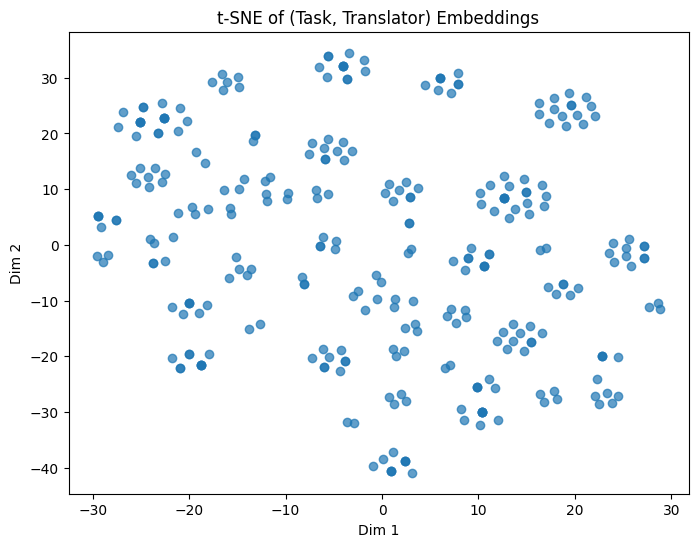

In [38]:
# For N random (task, translator) pairs
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

n_samples = 300
idxs = np.random.choice(len(data), n_samples, replace=False)
samples = data.iloc[idxs]
embeddings = []
for _, row in samples.iterrows():
    task_vec = encode_task(row)
    tr_id = translator_encoder.transform([row['TRANSLATOR']])[0]
    emb = get_embedding(task_vec, tr_id)
    embeddings.append(emb)
embeddings = np.vstack(embeddings)
tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(embeddings)
plt.figure(figsize=(8,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], alpha=0.7)
plt.title("t-SNE of (Task, Translator) Embeddings")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()

##Constraint Filtering (before ranking)

In [39]:
def compute_multitaskers(data):
    """
    Returns a set of translators who, at least once, had overlapping task intervals.
    """
    # Only keep rows with valid interval data
    df = data.dropna(subset=['TRANSLATOR', 'START', 'END']).copy()
    df['START'] = pd.to_datetime(df['START'])
    df['END'] = pd.to_datetime(df['END'])
    multitaskers = set()
    for tr, tr_df in tqdm(df.groupby('TRANSLATOR'), desc="Detecting multitaskers"):
        if len(tr_df) < 2:
            continue
        # Create a cartesian product (all task pairs for that translator)
        merged = tr_df.merge(tr_df, on='TRANSLATOR', suffixes=('_A', '_B'))
        merged = merged[merged['TASK_ID_A'] != merged['TASK_ID_B']]
        # Check for overlap
        overlap = (merged['START_A'] < merged['END_B']) & (merged['START_B'] < merged['END_A'])
        if overlap.any():
            multitaskers.add(tr)
    return multitaskers

multitaskers_set = compute_multitaskers(data)


Detecting multitaskers: 100%|██████████| 228/228 [00:30<00:00,  7.36it/s]


In [40]:
def filter_translators(task_row):
    """
    Vectorized and efficient assignment filter for a new task.
    Returns list of eligible translator names.
    """

    src = task_row['SOURCE_LANG']
    tgt = task_row['TARGET_LANG']
    task_type = task_row['TASK_TYPE']
    client = task_row['MANUFACTURER']
    task_start = pd.to_datetime(task_row.get('START', None))
    task_end = pd.to_datetime(task_row.get('END', None))

    # LANGUAGE PAIR
    eligible = costs[(costs['SOURCE_LANG'] == src) & (costs['TARGET_LANG'] == tgt)]['TRANSLATOR'].unique()
    eligible = set(eligible)

    # AVAILABILITY & MULTITASKING (Vectorized)
    # Only those working that day
    if pd.notna(task_start):
        weekday_map = {0: 'MON', 1: 'TUES', 2: 'WED', 3: 'THURS', 4: 'FRI', 5: 'SAT', 6: 'SUN'}
        day_col = weekday_map[task_start.weekday()]
        working_today = set(schedules[schedules[day_col] == 1]['NAME'])
        eligible &= working_today

    # Remove non-multitaskers with task overlap (vectorized)
    if pd.notna(task_start) and pd.notna(task_end):
        # Get all non-multitaskers still eligible
        nonmulti = [tr for tr in eligible if tr not in multitaskers_set]
        # For each, check for overlap
        tr_data = data[data['TRANSLATOR'].isin(nonmulti)].copy()
        tr_data = tr_data.dropna(subset=['START', 'END'])
        tr_data['START'] = pd.to_datetime(tr_data['START'])
        tr_data['END'] = pd.to_datetime(tr_data['END'])
        tr_data = tr_data[(tr_data['START'] < task_end) & (task_start < tr_data['END'])]
        overlapping = set(tr_data['TRANSLATOR'])
        eligible -= overlapping

    # COST
    client_row = clients[clients['CLIENT_NAME'] == client]
    if not client_row.empty:
        max_rate = client_row.iloc[0]['SELLING_HOURLY_PRICE']
        eligible_cost = set(costs[(costs['SOURCE_LANG'] == src) &
                                  (costs['TARGET_LANG'] == tgt) &
                                  (costs['HOURLY_RATE'] <= max_rate)]['TRANSLATOR'])
        eligible &= eligible_cost

    # MINIMUM QUALITY
    min_quality = client_row.iloc[0]['MIN_QUALITY'] if (not client_row.empty and 'MIN_QUALITY' in client_row.columns) else None
    if min_quality is not None and 'QUALITY_EVALUATION' in data.columns:
        qeval = data.groupby('TRANSLATOR')['QUALITY_EVALUATION'].mean()
        eligible_quality = set(qeval[qeval >= min_quality].index)
        eligible &= eligible_quality

    # EXPERIENCE
    experience_types = ['TEST', 'ProofReading', 'LanguageLead', 'PostEditing', 'Spotcheck']
    if task_type in experience_types:
        relevant = data[(data['TRANSLATOR'].isin(eligible)) &
                        ((data['MANUFACTURER'] == client) | (data['TASK_TYPE'] == task_type))]
        eligible_experience = set(relevant['TRANSLATOR'])
        eligible &= eligible_experience

    # WILDCARD
    if len(eligible) == 0 and not client_row.empty and 'WILDCARD' in client_row.columns:
        wildcard = client_row.iloc[0]['WILDCARD']
        if wildcard == 'COST':
            eligible = set(costs[(costs['SOURCE_LANG'] == src) & (costs['TARGET_LANG'] == tgt)]['TRANSLATOR'])
            eligible &= working_today
        elif wildcard == 'QUALITY':
            eligible = eligible_cost
        elif wildcard == 'EXPERIENCE':
            eligible = eligible_quality

    return list(eligible)


## Evaluation Function

##For New Task Assignment:

In [42]:
import numpy as np
from tqdm import tqdm

def batch_get_embeddings(task_vec, translator_ids):
    """
    Vectorized embedding for many (task_vec, translator_id) pairs.
    task_vec: (n_feats,) numpy array
    translator_ids: list of int
    Returns: (N, emb_dim) numpy array
    """
    model.eval()
    n = len(translator_ids)
    with torch.no_grad():
        task_tensor = torch.tensor(np.tile(task_vec, (n,1)), dtype=torch.float32).to(device)  # [N, n_feats]
        translator_tensor = torch.tensor(translator_ids, dtype=torch.long).to(device)         # [N]
        embs = model(task_tensor, translator_tensor)  # [N, emb_dim]
    return embs.cpu().numpy()

def batch_evaluate_fast(data, k_list=[1, 3, 5], n_sample=200):
    """
    Fast, batched evaluation using vectorized model calls.
    Compatible with online hard negative mining and mixed features.
    """
    hit_at_k = {k: 0 for k in k_list}
    reciprocal_ranks = []
    mean_ranks = []

    task_features = [
        'TASK_TYPE', 'SOURCE_LANG', 'TARGET_LANG', 'MANUFACTURER',
        'MANUFACTURER_SECTOR', 'MANUFACTURER_INDUSTRY_GROUP', 'MANUFACTURER_INDUSTRY',
        'MANUFACTURER_EXP', 'MANUFACTURER_SECTOR_EXP', 'MANUFACTURER_INDUSTRY_GROUP_EXP'
    ]

    sample_data = data.sample(n=min(n_sample, len(data)), random_state=42)

    for idx, row in tqdm(sample_data.iterrows(), total=len(sample_data)):
        task_row = {feat: row[feat] for feat in task_features if feat in row}
        for extra in ['START', 'END']:
            if extra in row:
                task_row[extra] = row[extra]
        real_translator = row['TRANSLATOR']

        eligible_translators = filter_translators(task_row)
        eligible_translators = [tr for tr in eligible_translators if tr != real_translator]
        if not eligible_translators:
            continue

        all_trs = eligible_translators + [real_translator]
        tr_ids = [translator_encoder.transform([tr])[0] for tr in all_trs]

        task_enc = encode_task(task_row)
        embs = batch_get_embeddings(task_enc, tr_ids)  # [num_candidates, emb_dim]

        dists = np.linalg.norm(embs, axis=1)
        sorted_indices = np.argsort(dists)
        ranked_translators = [all_trs[i] for i in sorted_indices]

        try:
            rank = ranked_translators.index(real_translator) + 1
        except ValueError:
            continue

        for k in k_list:
            if rank <= k:
                hit_at_k[k] += 1
        reciprocal_ranks.append(1.0 / rank)
        mean_ranks.append(rank)

    num_tasks = len(reciprocal_ranks)
    hit_at_k = {k: hit_at_k[k] / num_tasks for k in k_list}
    mrr = np.mean(reciprocal_ranks)
    mean_rank = np.mean(mean_ranks)

    print(f"Evaluated on {num_tasks} tasks.")
    print("Hit@k:", hit_at_k)
    print("MRR:", mrr)
    print("Mean Rank:", mean_rank)
    return hit_at_k, mrr, mean_rank


In [43]:
hit_at_k, mrr, mean_rank = batch_evaluate_fast(data, k_list=[1,3,5], n_sample=200)

100%|██████████| 200/200 [00:07<00:00, 25.04it/s]

Evaluated on 200 tasks.
Hit@k: {1: 0.045, 3: 0.09, 5: 0.175}
MRR: 0.12280408991957316
Mean Rank: 28.93


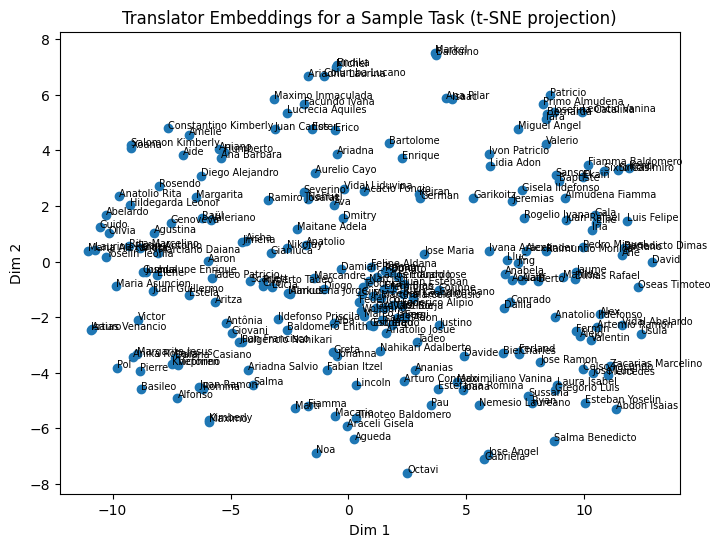

In [44]:
# Get all translator embeddings for a fixed (example) task
from sklearn.manifold import TSNE

example_task_row = data.sample(1).iloc[0]
task_vec = encode_task(example_task_row)
all_trs = list(translator_encoder.classes_)
tr_ids = [translator_encoder.transform([tr])[0] for tr in all_trs]
embs = batch_get_embeddings(task_vec, tr_ids)  # shape (n_translators, emb_dim)

tsne = TSNE(n_components=2, random_state=42)
embs_2d = tsne.fit_transform(embs)

plt.figure(figsize=(8,6))
plt.scatter(embs_2d[:,0], embs_2d[:,1])
for i, tr in enumerate(all_trs):
    plt.text(embs_2d[i,0], embs_2d[i,1], tr, fontsize=7)
plt.title("Translator Embeddings for a Sample Task (t-SNE projection)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()

##plotting Confusion Matrix and visualizations

In [45]:
import pandas as pd
from collections import defaultdict
from tqdm import tqdm

def confusion_matrix_breakdown(data, n_sample=200):
    """
    Returns a DataFrame: rows = true translator, columns = assigned (top-1) translator,
    values = count of assignments over the sample. Uses all model logic and hard constraints.
    """
    counts = defaultdict(lambda: defaultdict(int))

    # Your task features order
    task_features = [
        'TASK_TYPE', 'SOURCE_LANG', 'TARGET_LANG', 'MANUFACTURER',
        'MANUFACTURER_SECTOR', 'MANUFACTURER_INDUSTRY_GROUP', 'MANUFACTURER_INDUSTRY',
        'MANUFACTURER_EXP', 'MANUFACTURER_SECTOR_EXP', 'MANUFACTURER_INDUSTRY_GROUP_EXP'
    ]

    sample_data = data.sample(n=min(n_sample, len(data)), random_state=42)

    for idx, row in tqdm(sample_data.iterrows(), total=len(sample_data)):
        task_row = {feat: row[feat] for feat in task_features if feat in row}
        # Include 'START' and 'END' if available for filter_translators
        for extra in ['START', 'END']:
            if extra in row:
                task_row[extra] = row[extra]
        real_translator = row['TRANSLATOR']

        eligible_translators = filter_translators(task_row)
        if not eligible_translators:
            continue

        task_enc = encode_task(task_row)
        results = []
        for tr_name in eligible_translators:
            tr_id = translator_encoder.transform([tr_name])[0]
            emb = get_embedding(task_enc, tr_id)
            results.append((tr_name, np.linalg.norm(emb)))

        if not results:
            continue

        # Who does the model recommend as top-1?
        predicted_translator = sorted(results, key=lambda x: x[1])[0][0]
        counts[real_translator][predicted_translator] += 1

    # Build DataFrame
    all_translators = set(counts.keys()) | {k for v in counts.values() for k in v.keys()}
    all_translators = sorted(all_translators)
    matrix = pd.DataFrame(0, index=all_translators, columns=all_translators)
    for real in counts:
        for pred in counts[real]:
            matrix.loc[real, pred] = counts[real][pred]
    # Row-normalized version
    matrix_norm = matrix.div(matrix.sum(axis=1), axis=0).fillna(0)
    return matrix, matrix_norm

100%|██████████| 200/200 [00:18<00:00, 10.73it/s]


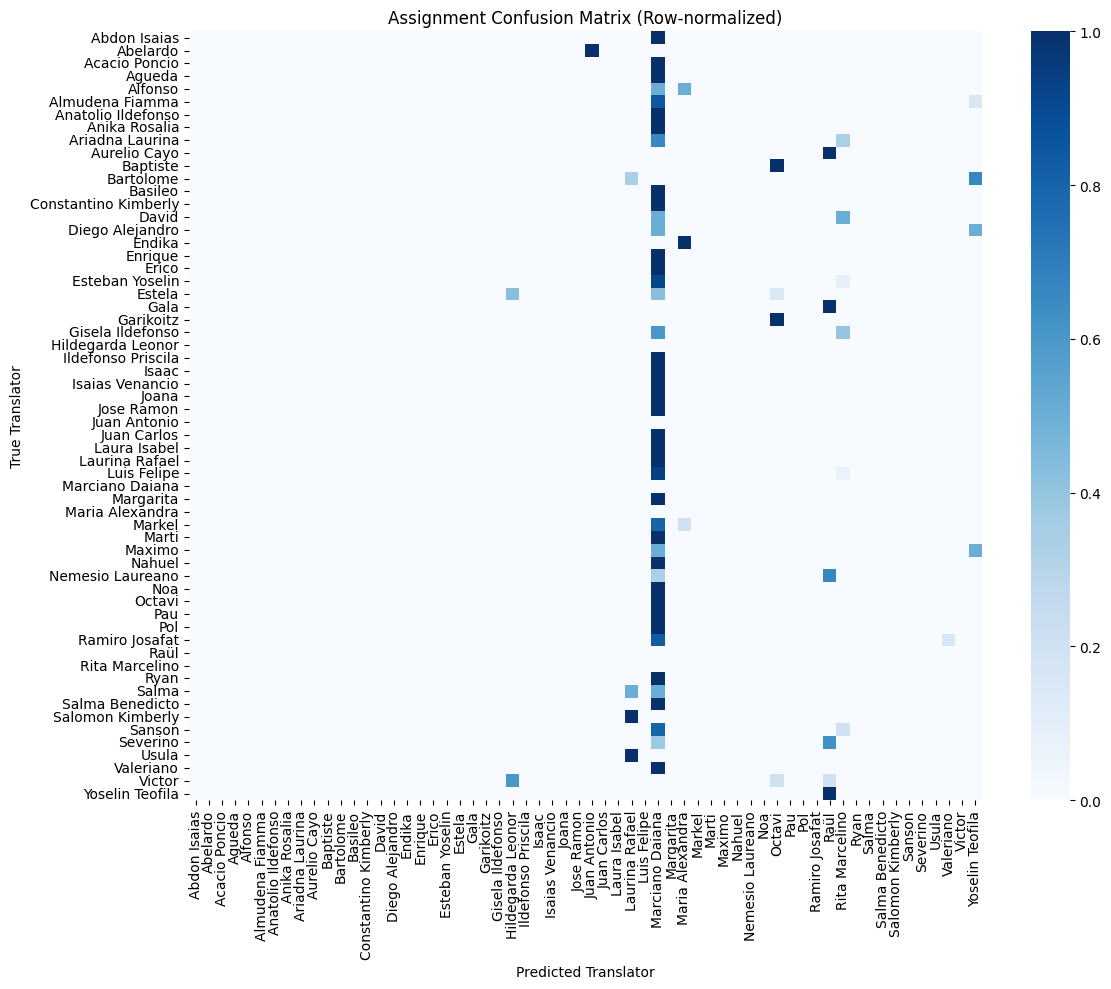

In [46]:
import seaborn as sns

matrix, matrix_norm = confusion_matrix_breakdown(data, n_sample=200)

plt.figure(figsize=(12,10))
sns.heatmap(matrix_norm, cmap="Blues", annot=False, fmt=".2f",
            xticklabels=matrix_norm.columns, yticklabels=matrix_norm.index)
plt.title("Assignment Confusion Matrix (Row-normalized)")
plt.xlabel("Predicted Translator")
plt.ylabel("True Translator")
plt.tight_layout()
plt.show()


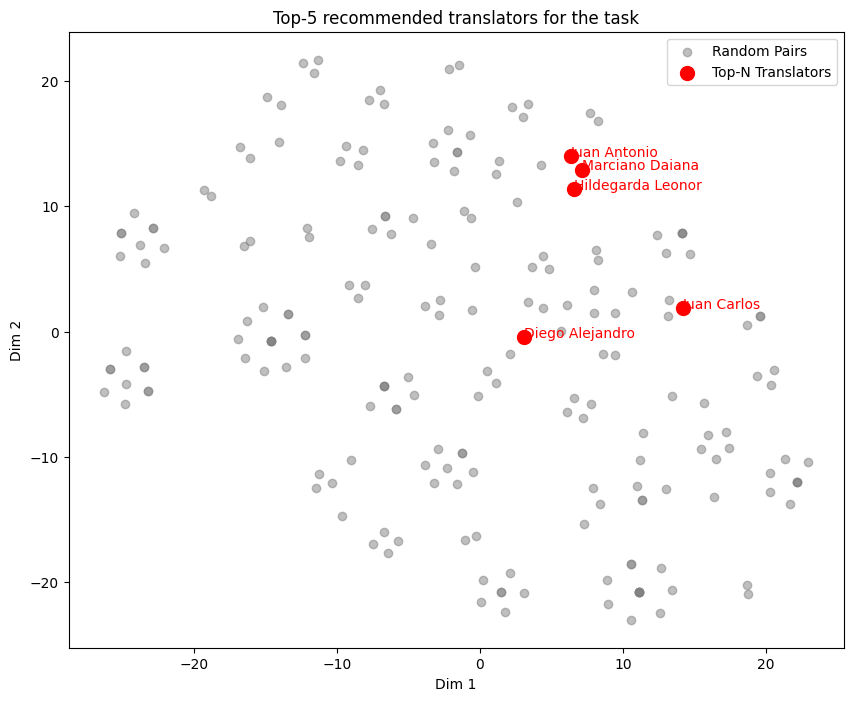

Top-N translators: ['Marciano Daiana', 'Juan Carlos', 'Juan Antonio', 'Diego Alejandro', 'Hildegarda Leonor']


In [47]:
def plot_task_topN_cluster(data, task_row, N=5, n_samples=200):
    #Compute embeddings for random pairs for background
    idxs = np.random.choice(len(data), n_samples, replace=False)
    samples = data.iloc[idxs]
    emb_bg = []
    for _, row in samples.iterrows():
        task_vec = encode_task(row)
        tr_id = translator_encoder.transform([row['TRANSLATOR']])[0]
        emb = get_embedding(task_vec, tr_id)
        emb_bg.append(emb)
    emb_bg = np.vstack(emb_bg)
    tsne = TSNE(n_components=2, random_state=42)
    emb_2d_bg = tsne.fit_transform(emb_bg)

    #Compute embeddings for top-N translators for the given task
    eligible = filter_translators(task_row)
    scores = []
    task_vec = encode_task(task_row)
    for tr in eligible:
        tr_id = translator_encoder.transform([tr])[0]
        emb = get_embedding(task_vec, tr_id)
        scores.append((tr, emb, np.linalg.norm(emb)))
    scores.sort(key=lambda x: x[2])
    topN = scores[:N]

    # Get embeddings for top-N translators
    emb_topN = np.vstack([x[1] for x in topN])
    # Project topN embeddings using the same t-SNE transform as background
    # To do this, refit t-SNE on bg + topN
    emb_total = np.vstack([emb_bg, emb_topN])
    emb_2d_total = TSNE(n_components=2, random_state=42).fit_transform(emb_total)
    emb_2d_bg, emb_2d_topN = emb_2d_total[:n_samples], emb_2d_total[n_samples:]

    # Step 3: Plot
    plt.figure(figsize=(10,8))
    plt.scatter(emb_2d_bg[:,0], emb_2d_bg[:,1], color='gray', alpha=0.5, label="Random Pairs")
    plt.scatter(emb_2d_topN[:,0], emb_2d_topN[:,1], color='red', s=100, label="Top-N Translators")
    for i, (tr, _, _) in enumerate(topN):
        plt.text(emb_2d_topN[i,0], emb_2d_topN[i,1], tr, color='red', fontsize=10)
    plt.title(f"Top-{N} recommended translators for the task")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.legend()
    plt.show()

    print("Top-N translators:", [x[0] for x in topN])

# Example usage for a real task:
# Pick a real or sample task row:
task_row = data.sample(1).iloc[0].to_dict()
plot_task_topN_cluster(data, task_row, N=5, n_samples=200)


In [48]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def plot_tsne_colored(data, color_field='TASK_TYPE', n_samples=200):
    # Sample N random (task, translator) pairs for visualization
    idxs = np.random.choice(len(data), n_samples, replace=False)
    samples = data.iloc[idxs]
    embeddings = []
    color_labels = []
    for _, row in samples.iterrows():
        task_vec = encode_task(row)
        tr_id = translator_encoder.transform([row['TRANSLATOR']])[0]
        emb = get_embedding(task_vec, tr_id)
        embeddings.append(emb)
        if color_field == 'LANG_PAIR':
            color_labels.append(f"{row['SOURCE_LANG']}-{row['TARGET_LANG']}")
        else:
            color_labels.append(row[color_field])
    embeddings = np.vstack(embeddings)
    tsne = TSNE(n_components=2, random_state=42)
    emb_2d = tsne.fit_transform(embeddings)

    # Build color palette
    unique_labels = list(sorted(set(color_labels)))
    color_map = {lab: i for i, lab in enumerate(unique_labels)}
    colors = [color_map[lab] for lab in color_labels]
    cmap = plt.get_cmap('tab20', len(unique_labels))

    plt.figure(figsize=(10,8))
    scatter = plt.scatter(emb_2d[:,0], emb_2d[:,1], c=colors, cmap=cmap, alpha=0.7)
    plt.title(f"t-SNE of (Task, Translator) Embeddings colored by {color_field}")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    cb = plt.colorbar(scatter, ticks=range(len(unique_labels)))
    cb.ax.set_yticklabels(unique_labels)
    plt.show()


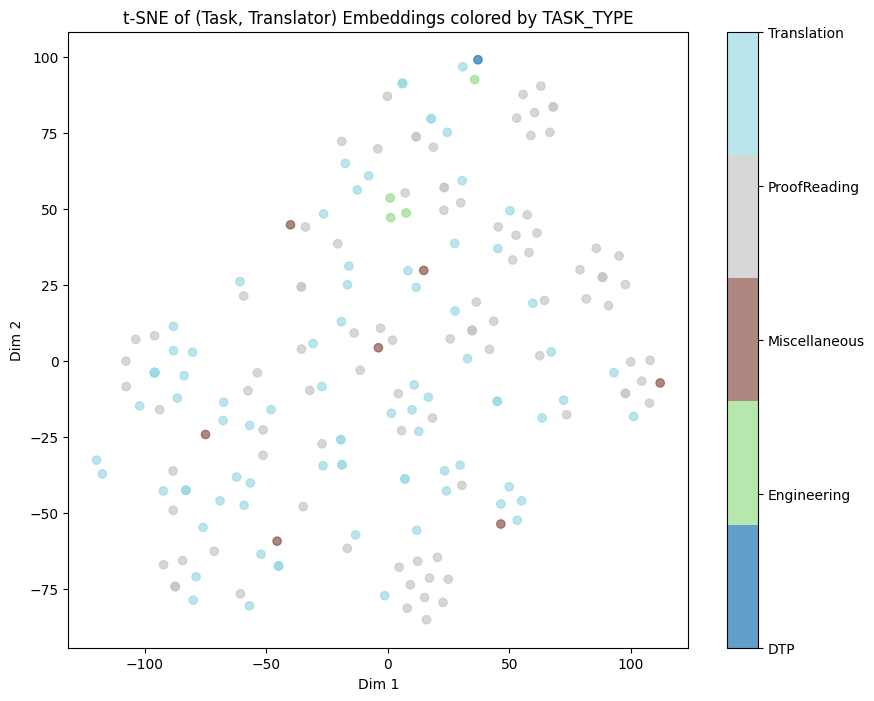

In [49]:
 plot_tsne_colored(data, color_field='TASK_TYPE')